In [35]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

# from tensorflow.keras import layers
# from tensorflow.keras import models
from IPython import display

# Set the seed value for experiment reproducibility.
seed = 42
EPOCHS = 100
tf.random.set_seed(seed)
np.random.seed(seed)

In [36]:
# DATASET_PATH = "../Data/DigitDataset" # Digits
DATASET_PATH  = "../Data/mini_speech_commands/" # Words

In [37]:
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=DATASET_PATH,
    batch_size=64,
    validation_split=0.2,
    seed=0,
    output_sequence_length=8000,
    subset='both')

label_names = np.array(train_ds.class_names)
print()
print("label names:", label_names)

Found 8000 files belonging to 8 classes.
Using 6400 files for training.
Using 1600 files for validation.

label names: ['down' 'go' 'left' 'no' 'right' 'stop' 'up' 'yes']


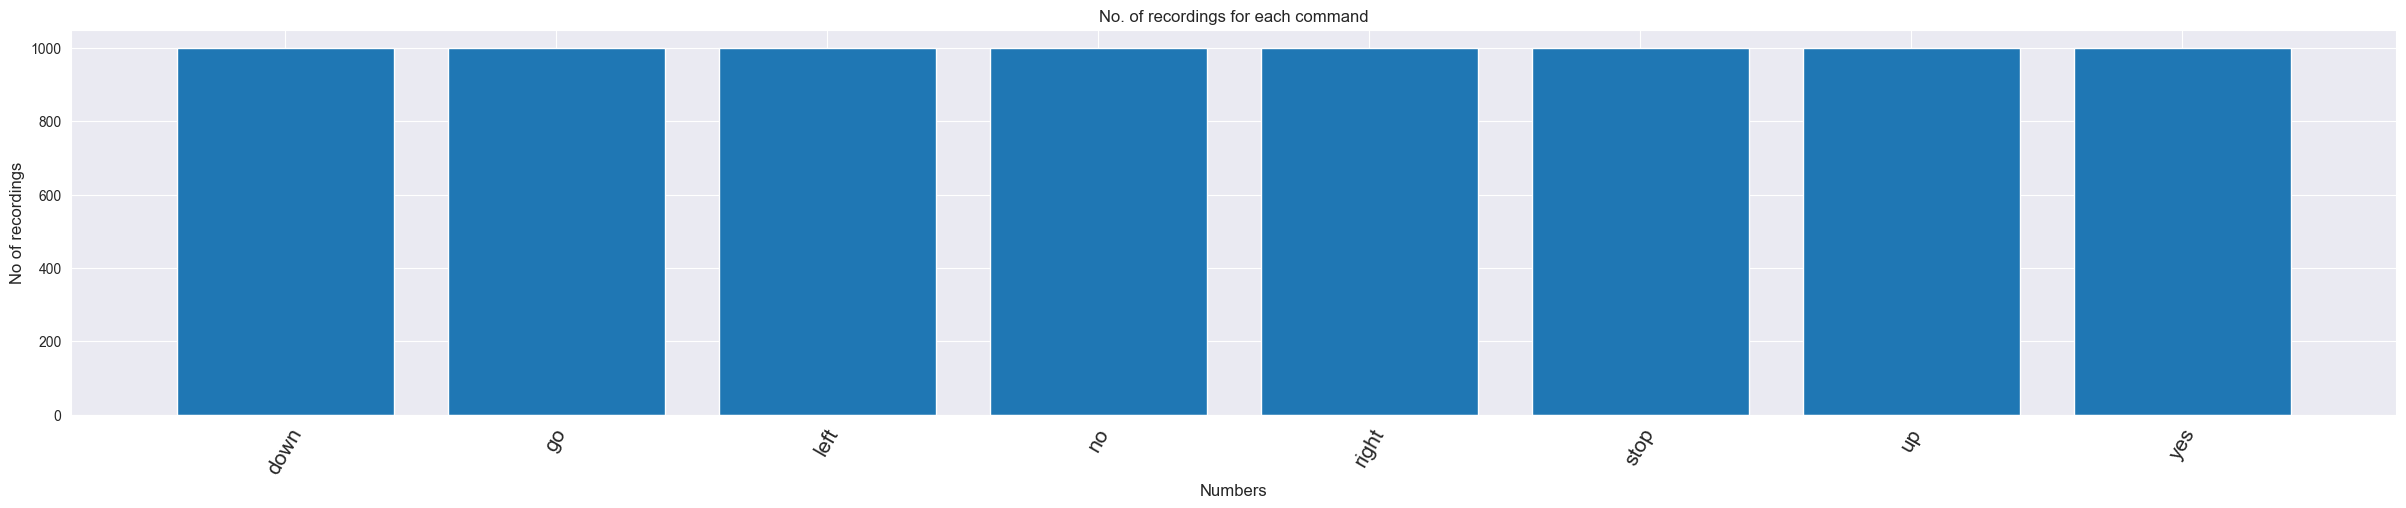

In [38]:
no_of_recordings=[]
for label in label_names:
    waves = [f for f in os.listdir(DATASET_PATH + '/'+ label) if f.endswith('.wav')]
    no_of_recordings.append(len(waves))

#plot
plt.figure(figsize=(30,5))
index = np.arange(len(label_names))
plt.bar(index, no_of_recordings)
plt.xlabel('Numbers', fontsize=12)
plt.ylabel('No of recordings', fontsize=12)
plt.xticks(index, label_names, fontsize=15, rotation=60)
plt.title('No. of recordings for each command')
plt.show()

In [39]:
train_ds.element_spec

(TensorSpec(shape=(None, 8000, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

In [40]:
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

In [41]:
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

In [42]:
for example_audio, example_labels in train_ds.take(1):
  print(example_audio.shape)
  print(example_labels.shape)

(64, 8000)
(64,)


In [43]:
label_names[[1,1,3,0]]

array(['go', 'go', 'no', 'down'], dtype='<U5')

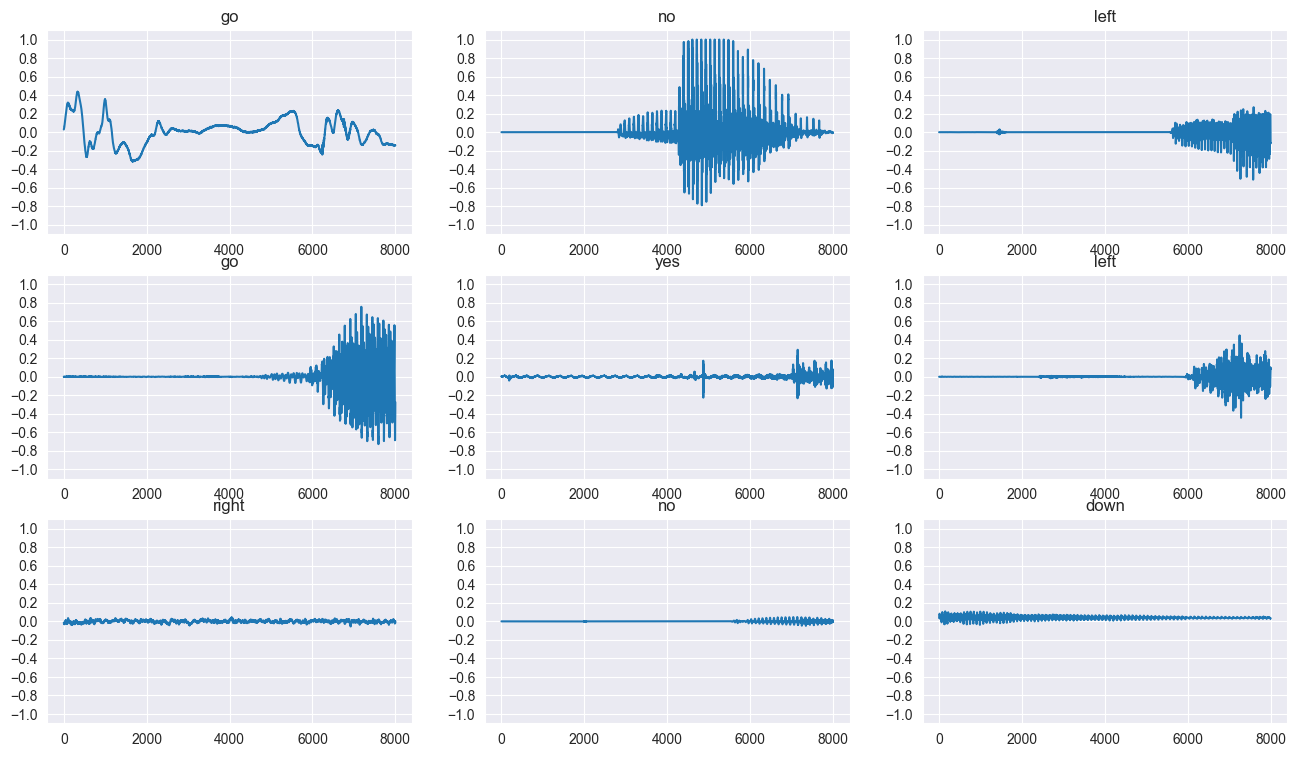

In [44]:
rows = 3
cols = 3
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
  if i>=n:
    break
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(example_audio[i].numpy())
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  label = label_names[example_labels[i]]
  ax.set_title(label)
  ax.set_ylim([-1.1,1.1])

plt.show()

In [45]:
def get_spectrogram(waveform):
  # Convert the waveform to a spectrogram via a STFT.
  spect = tf.signal.stft(
      waveform, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spect = tf.abs(spect)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spect = spect[..., tf.newaxis]
  return spect


In [46]:
for i in range(3):
  label = label_names[example_labels[i]]
  waveform = example_audio[i]
  spectrogram = get_spectrogram(waveform)

  print('Label:', label)
  print('Waveform shape:', waveform.shape)
  print('Spectrogram shape:', spectrogram.shape)
  print('Audio playback')
  display.display(display.Audio(waveform, rate=8000))

Label: go
Waveform shape: (8000,)
Spectrogram shape: (61, 129, 1)
Audio playback


Label: no
Waveform shape: (8000,)
Spectrogram shape: (61, 129, 1)
Audio playback


Label: left
Waveform shape: (8000,)
Spectrogram shape: (61, 129, 1)
Audio playback


In [47]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

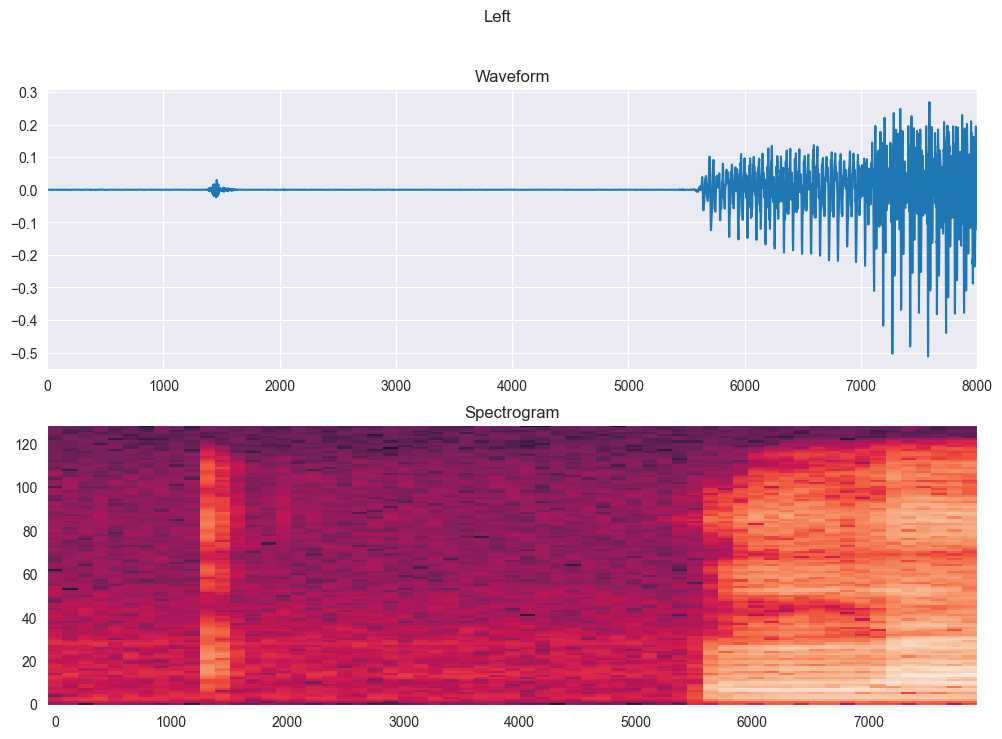

In [48]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 8000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()

In [49]:
def make_spec_ds(ds):
  return ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

In [50]:
train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)

In [51]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break

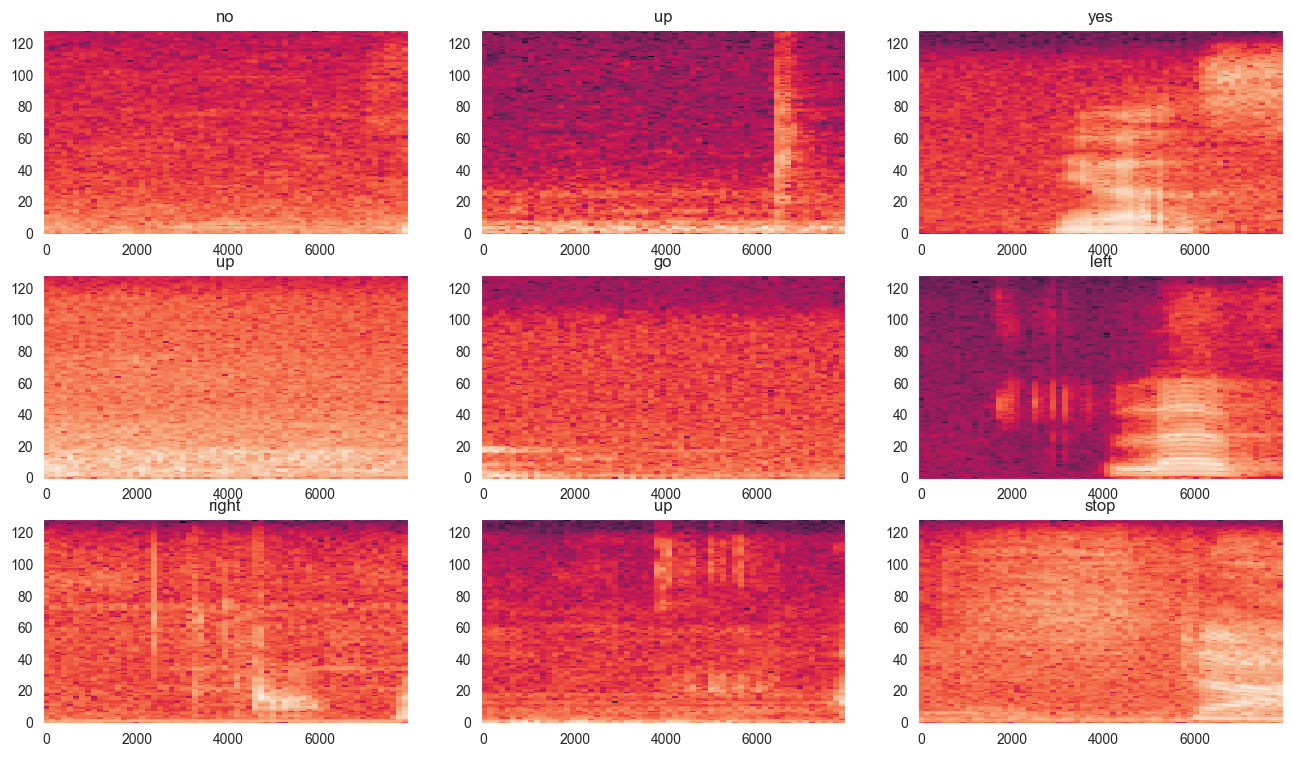

In [52]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(label_names[example_spect_labels[i].numpy()])

plt.show()

In [53]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)


In [54]:
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(label_names)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = tf.keras.layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=input_shape),
    # Downsample the input.
    tf.keras.layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_labels),
])

model.summary()

Input shape: (61, 129, 1)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_1 (Resizing)       (None, 32, 32, 1)         0         
                                                                 
 normalization_1 (Normalizat  (None, 32, 32, 1)        3         
 ion)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 30, 30, 32)        320       
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)        

In [55]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [56]:
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/100
100/100 [==============================] - 1s 7ms/step - loss: 1.9041 - accuracy: 0.2786 - val_loss: 1.6712 - val_accuracy: 0.4323
Epoch 2/100
100/100 [==============================] - 0s 4ms/step - loss: 1.6035 - accuracy: 0.4120 - val_loss: 1.4171 - val_accuracy: 0.5130
Epoch 3/100
100/100 [==============================] - 0s 4ms/step - loss: 1.4137 - accuracy: 0.4923 - val_loss: 1.2515 - val_accuracy: 0.5820
Epoch 4/100
100/100 [==============================] - 0s 4ms/step - loss: 1.2676 - accuracy: 0.5427 - val_loss: 1.1444 - val_accuracy: 0.6341
Epoch 5/100
100/100 [==============================] - 0s 4ms/step - loss: 1.1721 - accuracy: 0.5753 - val_loss: 1.0411 - val_accuracy: 0.6445
Epoch 6/100
100/100 [==============================] - 0s 4ms/step - loss: 1.0750 - accuracy: 0.6066 - val_loss: 1.0232 - val_accuracy: 0.6380
Epoch 7/100
100/100 [==============================] - 0s 4ms/step - loss: 1.0184 - accuracy: 0.6255 - val_loss: 0.9984 - val_accuracy: 0.6680

Text(0, 0.5, 'Accuracy [%]')

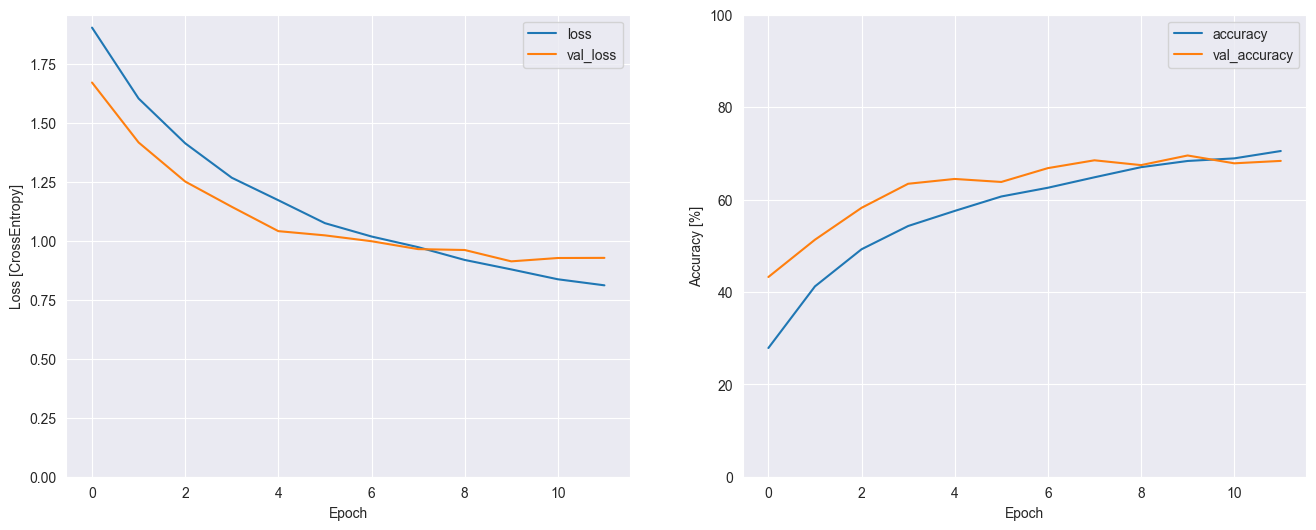

In [57]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')


In [58]:
model.evaluate(test_spectrogram_ds, return_dict=True)

13/13 [==============================] - 0s 18ms/step - loss: 0.9680 - accuracy: 0.6659


{'loss': 0.9680248498916626, 'accuracy': 0.6658653616905212}

In [59]:
y_pred = model.predict(test_spectrogram_ds)

13/13 [==============================] - 0s 1ms/step


In [60]:
y_pred = tf.argmax(y_pred, axis=1)

In [61]:
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

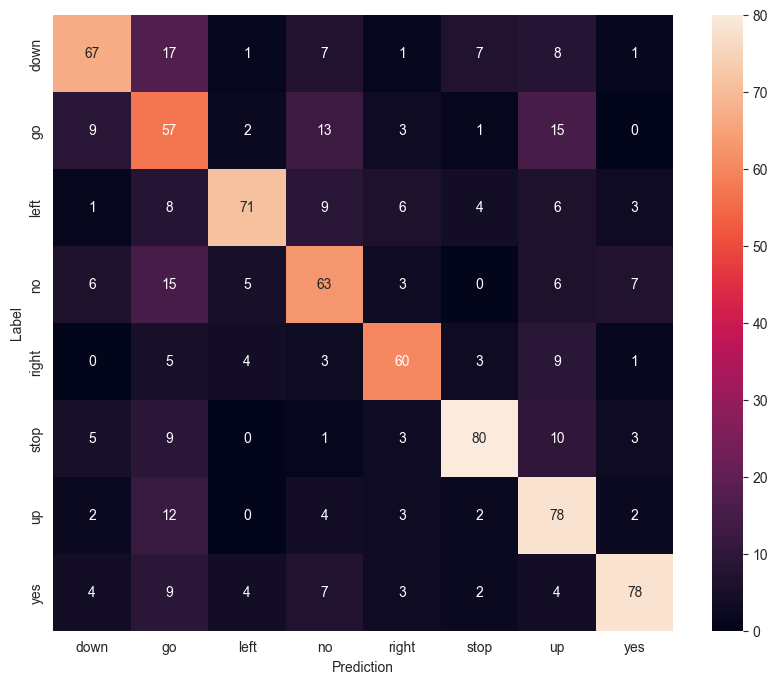

In [62]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

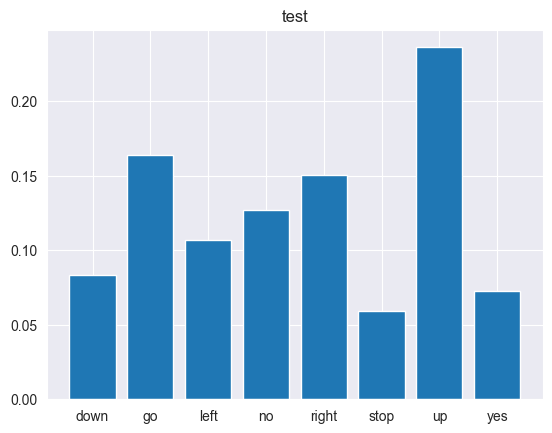

In [71]:
x = '../Data/AudioFragments/test.wav'
x = tf.io.read_file(str(x))
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=8000,)
x = tf.squeeze(x, axis=-1)
waveform = x
x = get_spectrogram(x)
x = x[tf.newaxis,...]

prediction = model(x)
plt.bar(label_names, tf.nn.softmax(prediction[0]))
plt.title('test')
plt.show()

display.display(display.Audio(waveform, rate=8000))

# Model Export  <https://www.tensorflow.org/tutorials/audio/simple_audio>